<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/LTNE_model_rel4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from itertools import product
import math
import pathlib
import os
import tensorflow as tf
from typing import Dict, Tuple, List

In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [3]:
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [5]:
def ode_system(n, y, config:dict) -> list:
    T_f = y[:, 0:1]
    T_s = y[:, 1:2]

    # Compute first derivatives (jacobian) - only j=0 for 1D problem
    T_f_n = dde.grad.jacobian(T_f, n)
    T_s_n = dde.grad.jacobian(T_s, n)

    # Compute second derivatives (hessian) - only j=0 for 1D problem
    T_f_nn = dde.grad.hessian(T_f, n)
    T_s_nn = dde.grad.hessian(T_s, n)

    # Dynamic parameter handling
    def get_param(name):
      val = config["physics"][name]
      if name in config["physics"]["varying_params"]:
          if callable(val):
              return val(n)  # ✅ this evaluates Bi(x)
          elif isinstance(val, (list, np.ndarray)):
              return tf.convert_to_tensor(val, dtype=n.dtype)
      return tf.convert_to_tensor(val, dtype=n.dtype)

    eps = get_param('eps')
    k = get_param('k')
    delta = get_param('delta')
    beta = get_param('beta')
    Bi = get_param('Bi')

    # Equations
    eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

    eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

    return [eqn1, eqn2]

In [6]:
# Define geometry (1D domain from 0 to 1)
geom = dde.geometry.Interval(0, 1)

# Boundary conditions
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

# Dirichlet BC at x=1
bc_Tf_right = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
bc_Ts_right = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=1)

# Neumann BC at x=0
bc_Tf_left = dde.NeumannBC(geom, lambda x: 0, boundary_left, component=0)
bc_Ts_left = dde.NeumannBC(geom, lambda x: 0, boundary_left, component=1)

In [7]:
from deepxde.callbacks import EarlyStopping, PDEPointResampler

In [8]:
class PINNTrainer:
  def __init__(self, config: Dict):
    self.config = config #hyperparameters, geometry, etc

  def build_model(self, data: dde.data) -> dde.Model:
    """ Generic model builder """
    nn = dde.maps.FNN(
        [1] + [self.config["network"]["neurons"]] * self.config["network"]["layers"] + [2],
        self.config["training"]["activation"],
        "Glorot normal",
     )

    return dde.Model(data, nn)

  def train(self, model: dde.Model) -> dde.Model:
    #callbacks
    callbacks = [
       EarlyStopping(
            min_delta=1e-5,
            patience=6000,
            monitor="loss",
            start_from_epoch=1000
          ),
        PDEPointResampler(
            period=100,
            pde_points=True,
            bc_points=False
          )
      ]

    """ Generic model trainer """
    model.compile("adam", lr = self.config["training"]["lr"], loss_weights = self.config["training"]["lose_weights"])
    losshistory, train_state = model.train(iterations=self.config["training"]["epochs"], display_every = self.config["training"]["display_every"], callbacks = callbacks)


    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()
    return model, losshistory, train_state

In [19]:
#validation
def relation_dict(n: np.ndarray) -> dict:
  RELATIONS = {
      "relation_4_a" : {
            "network": { "neurons":100, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                         "epochs":10000, "display_every":1000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": [1, 0.7],
                "beta": 10,
                "Bi": lambda x: 50* tf.cast(1-x**2, x.dtype),
                "varying_params": ["Bi", "delta"]  # Specify which params vary
            }
         },
      "relation_4_b" : {
            "network": { "neurons":100, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                         "epochs":10000, "display_every":1000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": [1, 0.7],
                "beta": 10,
                "Bi": lambda x: 100* (tf.sin(tf.constant(np.pi, x.dtype) * x)**2),
                "varying_params": ["Bi", "delta"]  # Specify which params vary
            }
         }
  }
  return RELATIONS

In [10]:
def run_relation(relation_name: str, n: np.ndarray):
        """Handles any relation from the config without deepcopy issues"""
        config = relation_dict(n)[relation_name]
        results = {}
        # Prepare parameter combinations for other relations
        varying_params = config["physics"]["varying_params"]
        param_values = [
            config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
            for p in varying_params
        ]

        for combo in product(*param_values):
            param_str = "_".join(f"{p}={v}" for p,v in zip(varying_params, combo))
            print(f"\nTraining {relation_name} with {param_str}")

            # Create new config without deepcopy
            current_physics = config["physics"].copy()
            for p, v in zip(varying_params, combo):
                current_physics[p] = v

            current_config = {
                "network": config["network"],
                "training": config["training"],
                "physics": current_physics
            }

            # Training setup
            ode_wrapped = lambda x, y: ode_system(x, y, current_config)
            data = dde.data.PDE(
                geom,
                ode_wrapped,
                [bc_Tf_right, bc_Ts_right, bc_Tf_left, bc_Ts_left],
                num_domain=500,
                num_boundary=20
            )

            # Build and train model
            nn = dde.maps.FNN(
                [1] + [current_config["network"]["neurons"]] * current_config["network"]["layers"] + [2],
                current_config["training"]["activation"],
                "Glorot normal"
            )
            model = dde.Model(data, nn)

            model.compile(
                "adam",
                lr=current_config["training"]["lr"],
                loss_weights=current_config["training"]["lose_weights"],
            )
            losshistory, train_state = model.train(iterations=current_config["training"]["epochs"], display_every=1000)
            model.compile("L-BFGS-B")
            losshistory, train_state = model.train()

            # Store results
            T_pred = model.predict(n)
            results[param_str] = {
                "x": n.flatten(),
                "T_f": T_pred[:, 0:1],
                "T_s": T_pred[:, 1:2],
                "params": dict(zip(varying_params, combo))
            }
            # dde.saveplot(losshistory, train_state, issave=True, isplot=True)

        return results

In [21]:
def plot_grouped_by_Bi(results, title_prefix="PINN Prediction Grouped by Bi"):
    """
    For each unique Bi (from result key), plot all (Tf, Ts) curves for that Bi in one figure.
    """
    import matplotlib.pyplot as plt
    from collections import defaultdict

    # Step 1: Group results by Bi
    grouped = defaultdict(dict)
    for key, res in results.items():
        # Parse key like "delta=0_Bi=<function relation_dict.<locals>.<lambda> at 0x7d98eef32b60>"
        Bi_key = [kv for kv in key.split('_') if kv.startswith("Bi=")][0]
        grouped[Bi_key][key] = res

    # Step 2: Plot each Bi group in its own figure
    for Bi_label, group in grouped.items():
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10.colors

        for i, (label, res) in enumerate(group.items()):
            x = res["x"]
            T_f = res["T_f"].flatten()
            T_s = res["T_s"].flatten()
            color = colors[i % len(colors)]

            plt.plot(x, T_s, color=color, linestyle='-', label=f"{label} - T_s")
            plt.plot(x, T_f, color=color, linestyle='--', label=f"{label} - T_f")

        plt.xlabel("x")
        plt.ylabel("Temperature")
        plt.title(f"{title_prefix}: {Bi_label}")
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Training relation_4_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7d98d8929260>_delta=1
Compiling model...
Building feed-forward neural network...
'build' took 0.080751 s

'compile' took 3.498693 s

Training model...

0         [1.16e+05, 9.47e+04, 7.81e-01, 1.03e+01, 1.62e-02, 1.12e-01]    [1.16e+05, 9.47e+04, 7.81e-01, 1.03e+01, 1.62e-02, 1.12e-01]    []  
1000      [3.88e+01, 4.46e+01, 1.08e+01, 2.89e+01, 1.40e+02, 1.27e+02]    [3.88e+01, 4.46e+01, 1.08e+01, 2.89e+01, 1.40e+02, 1.27e+02]    []  
2000      [2.65e+01, 2.84e+01, 2.26e-01, 2.76e-02, 1.35e+01, 1.34e+01]    [2.65e+01, 2.84e+01, 2.26e-01, 2.76e-02, 1.35e+01, 1.34e+01]    []  
3000      [1.22e+00, 1.02e+00, 8.56e-03, 1.74e-04, 6.51e-01, 8.67e-01]    [1.22e+00, 1.02e+00, 8.56e-03, 1.74e-04, 6.51e-01, 8.67e-01]    []  
4000      [9.32e-01, 6.28e-01, 3.17e-03, 2.26e-04, 6.33e-02, 1.35e-01]    [9.32e-01, 6.28e-01, 3.17e-03, 2.26e-04, 6.33e-02, 1.35e-01]    []  
5000      [7.95e-01, 5.18e-01, 1.10e-03, 9.22e-06, 7.88

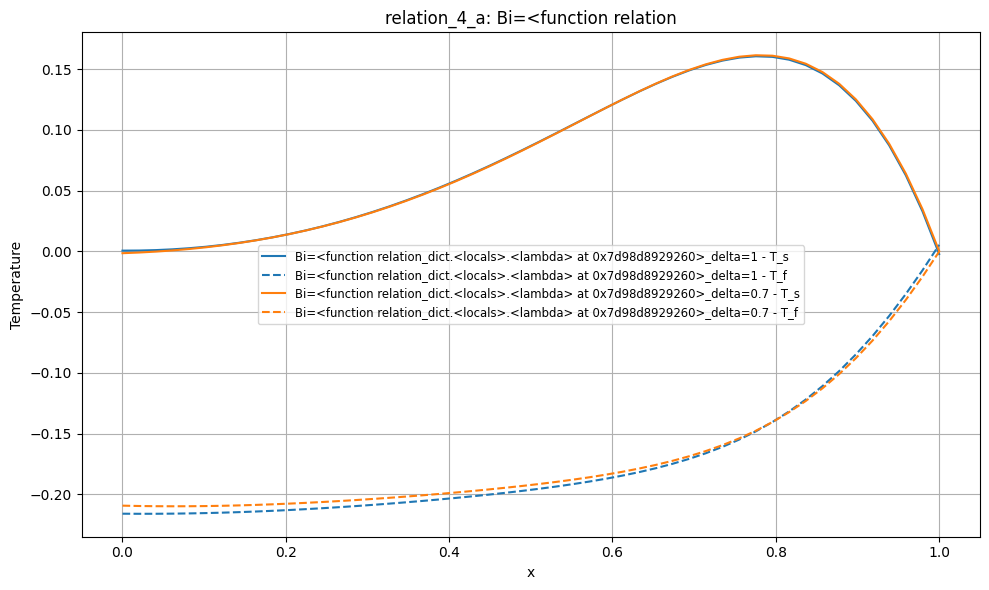


Training relation_4_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7d98d714d620>_delta=1
Compiling model...
Building feed-forward neural network...
'build' took 0.150559 s

'compile' took 3.833549 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.10e+05, 8.98e+04, 7.81e-01, 1.03e+01, 1.62e-02, 1.12e-01]    [1.10e+05, 8.98e+04, 7.81e-01, 1.03e+01, 1.62e-02, 1.12e-01]    []  
1000      [8.39e+02, 5.05e+02, 2.27e+01, 4.47e+01, 3.55e+01, 1.23e+02]    [8.39e+02, 5.05e+02, 2.27e+01, 4.47e+01, 3.55e+01, 1.23e+02]    []  
2000      [5.78e+02, 2.38e+02, 1.77e+01, 2.28e+01, 5.66e+01, 1.10e+02]    [5.78e+02, 2.38e+02, 1.77e+01, 2.28e+01, 5.66e+01, 1.10e+02]    []  
3000      [3.53e+02, 1.09e+02, 3.30e+01, 3.13e+00, 7.83e+01, 1.22e+02]    [3.53e+02, 1.09e+02, 3.30e+01, 3.13e+00, 7.83e+01, 1.22e+02]    []  
4000      [2.21e+02, 8.17e+01, 2.67e+01, 3.13e-0

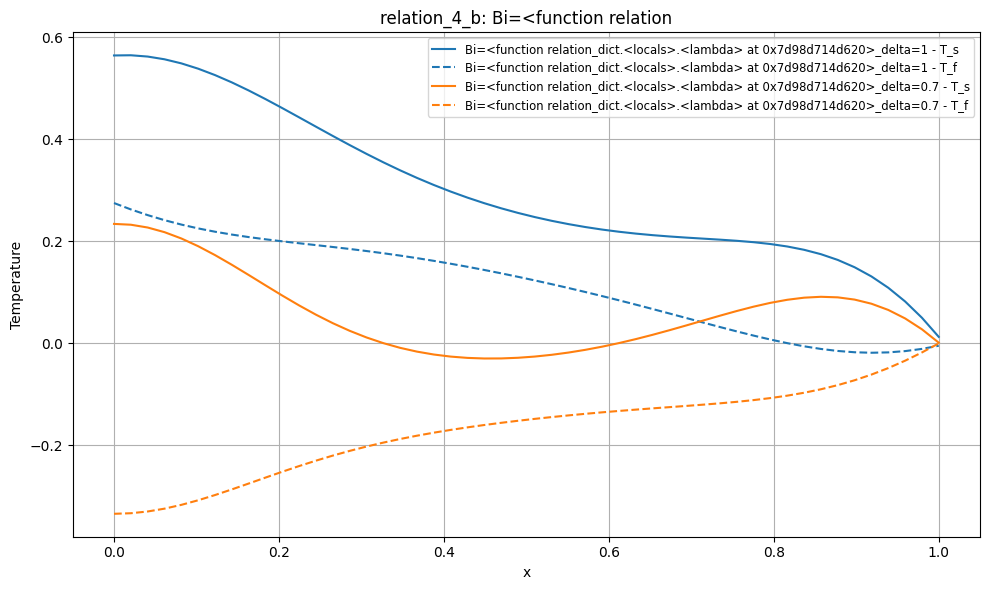

In [22]:
n = np.linspace(0, 1, 50).reshape(-1, 1)
all_results = {}

for relation in ["relation_4_a", "relation_4_b"]:
    all_results[relation] = run_relation(relation, n)
    plot_grouped_by_Bi(all_results[relation], title_prefix=relation)